In order to run this notebook locally you will need
- a local instsallation of feltor: follow the quick-start guide https://github.com/feltor-dev/feltor (we do need jsoncpp and netcdf, but not glfw, and a link to path/to/feltor/inc/dg in home/include)
- a local installation of simplesimdb: follow the quick-start guide https://github.com/mwiesenberger/simplesimdb
- to compile the cpp codes in this repository: type make in a shell


### Navier stokes equation including temperature dynamics

We now add temperature dynamics to the one-dimensional compressional Navier-Stokes equation
 \begin{align}
     \frac{\partial }{\partial t} n&= - \frac{\partial}{\partial x} un  \\
     \frac{\partial }{\partial t} nu&= - \frac{\partial}{\partial x} nu^2 - \frac{\partial}{\partial x} p + \nu_u\frac{\partial^2}{\partial x^2} u \\
     \frac{1}{\gamma -1 }\frac{\partial }{\partial t} nT &= -\frac{1}{\gamma -1 }\frac{\partial}{\partial x} n T u - p \frac{\partial}{\partial x} u + \nu_t \frac{\partial^2}{\partial x^2} T + \nu_u \left(\frac{\partial}{\partial x} u\right)^2  \\
     p &= (\gamma-1) n e = nT \\
     e &= \frac{1}{\gamma -1} T
 \end{align}
 Here, we choose $\gamma=3$ for a one-dimensional mono-atomic ideal gas. As a side remark we have the specific heats for an ideal gas $C_v = 1/(1-\gamma)$ and $\gamma = C_p / C_v$ as the ratio of specific heat. A good read on this is the introductory chapter in [Toro. "Riemann Solvers and Numerical Methods for Fluid Dynamic" 3rd edition 2009]
 
 We intend to study various schemes to discretize these equations. 
A robust approach is to use a so-called **staggered grid** discretization. This is a finite-volume type scheme and the 
basic idea is to shift the velocity grid by half a grid-point
such that the density and temperature are given on cell-centres while the velocity
is given on the faces.
Of the staggered discretizations, a particularly robust one seems
to be the one presented in {cite}`Herbin2013` where favourable qualities are shown:
- it is **positivity preserving**
- it is shown to satisfy an **entropy inequality**
- it is **shock-capturing**
- mass and energy conserving


We study various variations of the scheme including taking the pressure term explicitly and discretizing the Lagrangian form.
\begin{align}
    \frac{\partial }{\partial t} n&= - \frac{\partial}{\partial x} un  \\
     \frac{\partial }{\partial t} u&= - \frac{\partial}{\partial x} \frac{u^2}{2} - \frac{1}{n}\frac{\partial}{\partial x} p + \frac{\nu_u}{n}\frac{\partial^2}{\partial x^2} u \\
     \frac{\partial }{\partial t} T&= - u \frac{\partial}{\partial x} T - (\gamma-1) T \frac{\partial}{\partial x} u + (\gamma-1) \frac{\nu_t}{n} \frac{\partial^2}{\partial x^2} T + (\gamma-1) \frac{\nu_u}{n} \left( \frac{\partial}{\partial x} u \right)^2
\end{align}

The energy theorem of the above equations reads
\begin{align}
\frac{\partial }{\partial t} \left(\frac{1}{\gamma-1}nT + \frac{1}{2}nu^2\right)+ \frac{\partial}{\partial x} \left( \frac{\gamma+1}{\gamma-1}up +\frac{1}{2}nu^3 - \nu_t \frac{\partial}{\partial x} T - \nu_u u\frac{\partial }{\partial x} u\right) = 0 
\end{align}


### Regularization with density diffusion

Some numerical schemes need density diffusion in order to remain stable. By doing this, we need to be careful to not generate momentum or energy.
We thus follow {cite}`Guermond2016`
 \begin{align}
     \frac{\partial }{\partial t} n&= - \frac{\partial}{\partial x} (un ) + \nu_n\frac{\partial^2}{\partial x^2} n \\
     \frac{\partial }{\partial t} nu&= - \frac{\partial}{\partial x} nu^2 - \frac{\partial}{\partial x} p + \nu_u\frac{\partial^2}{\partial x^2} u + \nu_n \frac{\partial}{\partial x} \left( u\frac{\partial}{\partial x} n\right) \\
     \frac{\partial }{\partial t} \left(\frac{1}{\gamma-1}nT + \frac{1}{2}nu^2\right)
     &= - \frac{\partial}{\partial x} \left( \frac{\gamma+1}{\gamma-1}up +\frac{1}{2}nu^3\right) + \kappa \frac{\partial^2}{\partial x^2} T + \frac{\partial}{\partial x}\left( \nu_u u\frac{\partial }{\partial x} u + \frac{u^2}{2} \nu_n \frac{\partial}{\partial x}  n + \frac{1}{\gamma-1} \nu_n \frac{\partial}{\partial x}nT  \right) 
 \end{align}
 We see that particle diffusion introduces no net (volume integrated) momentum or energy. We have the equation of internal energy
\begin{align}
\frac{\partial }{\partial t} nT &= -\frac{\partial}{\partial x} n T u - (\gamma-1)p \frac{\partial}{\partial x} u + (\gamma-1)\kappa \frac{\partial^2}{\partial x^2} T + (\gamma-1)\nu_u \left(\frac{\partial}{\partial x} u\right)^2  + \nu_n \frac{\partial^2}{\partial x^2} nT
\end{align}

The Lagrangian form of the corrected momentum and energy equations reads
\begin{align}
     \frac{\partial }{\partial t} u&= - \frac{\partial}{\partial x} \frac{u^2}{2} -\frac{1}{n}\frac{\partial}{\partial x} p + \nu_u\frac{1}{n}\frac{\partial^2}{\partial x^2} u + \nu_n \frac{1}{n} \left(\frac{\partial}{\partial x} u\right)\left( \frac{\partial}{\partial x} n\right) \\
     \frac{\partial }{\partial t} T&= - u \frac{\partial}{\partial x} T - (\gamma-1) T \frac{\partial}{\partial x} u + \left( \frac{(\gamma-1)\kappa}{n} + \nu_n\right) \frac{\partial^2}{\partial x^2} T + (\gamma-1) \frac{\nu_u}{n} \left( \frac{\partial}{\partial x} u \right)^2 + \frac{2\nu_n}{n} \left( \frac{\partial}{\partial x}  n \right)\left(\frac{\partial}{\partial x} T\right)
\end{align}

In [1]:
import numpy as np
import simplesimdb as simplesim
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.animation as animation


In [2]:
# The code navier_stokes.cpp discretizes the above equations
# in space and time with various schemes.
# In the following we document the possible input parameters:
def make_navier_stokes_input() :
    return {
    "grid" : {
        "Nx" : 32, # number of grid points
        "x" : [0, 1], # spatial domain [x_0,x_1]
    },
#     "init":
#     {
#         # A sine wave in density and velocity and temperature
#         "type" : "wave",
#         "n_0" : 1,
#         "u_0" : 0.5,
#         "t_0": 0.5,
#         "A" : 0.2,
#         "B" : 0.1,
#         "C" : 0.1,
#         "k" : 4*np.pi
#     },
    "init":
    {
        "type" : "riemann",
        "x_a" : 0.5, # location of jump
        "n_l" : 1,   # density left of jump
        "n_r" : 1,   # density right of jump
        "u_l" : 0,   # velocity left of jump
        "u_r" : 0,   # velocity right of jump
        "t_l" : 0.01,   # temperature left of jump
        "t_r" : 100, # temperature right of jump
    },
#     "init":
#     {
#          # Manufactured solution without shock
#         "type" : "mms",
#         "n_0" : 1,
#         "u_0" : 0.5,
#         "t_0" : 0.75,
#         "A" : 0.2,
#         "B" : 0.1,
#         "C" : 0.2,
#         "k" : 4*np.pi,
#         "v" : 1 # velocity of mms solution
#     },
    "advection" : 
    {
        "type" : "staggered", 
        # staggered (allows variant)
        # velocity-staggered (allows variant)
        "variant" : "original"
        # original (The original scheme, 1st order)
        # explicit (Take pressure term explicitly)
        # slope-limiter (Use 2nd order flux)
        # slope-limiter-explicit (Use 2nd order flux
        #     and pressure term explicit)
    },
    "timestepper":
    {
        # The Additive Runge Kutta (ARK) method is a semi-implicit
        # embedded Runge Kutta scheme that works for all (explicit
        # and implicit) advection schemes above
        "type" : "ARK",
        "tableau" : "ARK-4-2-3",
        "rtol" : 1e-6, # relative tolerance
        "atol" : 1e-7  # absolute tolerance
        # The Embedded Runge Kutta (ERK) only works 
        # for explicit schemes
        # "type" : "ERK", 
        # "tableau" : "Bogacki-Shampine-4-2-3"
    },
    "physical":
    {
        "gamma" : 1.4, # 3 for monotamic 1-d ideal gas, 1.4 for Toro-test
        "nu_u" : 0.0, # viscosity
        "nu_n" : 0.0, # diffusivity (can be used to stabilize)
        "nu_t" : 0.0, # diffusivity (can be used to stabilize)
    },
    "bc" :
    {
         # one of PER, NEU, DIR, DIR_NEU, NEU_DIR
        "density": "NEU",
        "velocity" : "NEU",
        "temperature" : "NEU"
    },
    "output":
    {
        # The simulation will run from t = 0 to t = t_end
        "tend" : 0.035, # end time
        # Choose a number of (equidistant in time) outputs
        # in output file (excluding first)
        "maxout" : 20 
    }
    }

In [3]:
# This works completely analogous to the continuity case above
rep = simplesim.Repeater("./temp_navier_stokes","temp.json", "temp.nc")
rep.clean()
rep.run( make_navier_stokes_input(), error="display", stdout="ignore")
ncin = Dataset( "temp.nc", 'r', format="NETCDF4")
print( "FILE CONTENTS")
for v in ncin.variables:
    if v == "time" : 
        print(f"{v} {ncin.variables[v].shape}")
    else : 
        print( f"{v} {ncin.variables[v].shape}",
            f"\t{ ncin.variables[v].long_name}")

ncin.close()

FILE CONTENTS
time (21,)
x (32,) 	x-coordinate in Computational coordinate system
failed (21,) 	Accumulated Number of failed steps
duration (21,) 	Computation time for the latest output
nsteps (21,) 	Accumulated Number of calls to the RHS functor (including failed steps)
density (21, 32) 	Numerical density
velocity (21, 32) 	Numerical velocity
temperature (21, 32) 	Numerical temperature
density_ana (21, 32) 	Analytical solution to the density
velocity_ana (21, 32) 	Analytical solution to the velocity
temperature_ana (21, 32) 	Analytical solution to the temperature


In [4]:
# Again, we define a plotting routine that loops over
# parameters sets, runs simulations and plots the results
def plot_navier_stokes( p_list, save_fig = False, figure_name = "test.png"):
    frows = 2
    fcols = 2
    plt.rcParams.update({'font.size': 18})

    fig,axs=plt.subplots(frows,fcols,figsize=(fcols*10,frows*8),dpi= 80, facecolor='w', edgecolor='k')
    #https://matplotlib.org/stable/tutorials/colors/colormaps.html

    plotted = False
    for p in p_list :
        rep.clean()
        rep.run( p, error="display", stdout="ignore")
        ncin = Dataset( "temp.nc", 'r', format="NETCDF4")
        var = ncin.variables
        nsteps = var["nsteps"][-1]
        nfailed = var["failed"][-1]

        x = var["x"][:]

        l = f"{p['advection']['type']}"
        if( "variant" in p["advection"].keys() ):
            if (p['advection']['variant'] == "original") :
                l = l + " semi-implicit"
            else : 
                l = l + f" {p['advection']['variant']}"
        print(l)         
        print( f"\tFunction calls: {nsteps} Failed: {nfailed}")
        print(f"Nx = {p['grid']['Nx']}")
        ax = axs[0][0]
        im = ax.plot(x,var["density"][-1,:], p["ls"], label=l, lw=4)
        ax.set_title( f"density")
        ax.set_xlabel('x')
        ax.grid(True)
        ax = axs[0][1]
        im = ax.plot(x,var["velocity"][-1,:], p["ls"], label=l, lw=4)
        ax.set_title( f"velocity")
        ax.set_xlabel('x')
        ax.grid(True)
        ax = axs[1][0]
        im = ax.plot(x,var["temperature"][-1,:], p["ls"], label=l, lw=4)
        ax.set_title( f"temperature")
        ax.set_xlabel('x')
        ax.grid(True)
        ax = axs[1][1]
        pressure = var["density"][:,:]*var["temperature"][:,:]
        im = ax.plot(x,pressure[-1,:], p["ls"], label=l, lw=4)
        ax.set_title( f"pressure")
        ax.set_xlabel('x')
        ax.grid(True)
                            
        ncin.close()
    axs[0][0].legend()
    if save_fig :
        plt.savefig( figure_name, bbox_inches="tight")

As a first example we study the dam break over a dry bed without viscosity

Remember that energy and momentum can enter/leave the domain
velocity-staggered slope-limiter
	Function calls: 2671.0 Failed: 1.0
Nx = 100
staggered slope-limiter
	Function calls: 1791.0 Failed: 1.0
Nx = 100


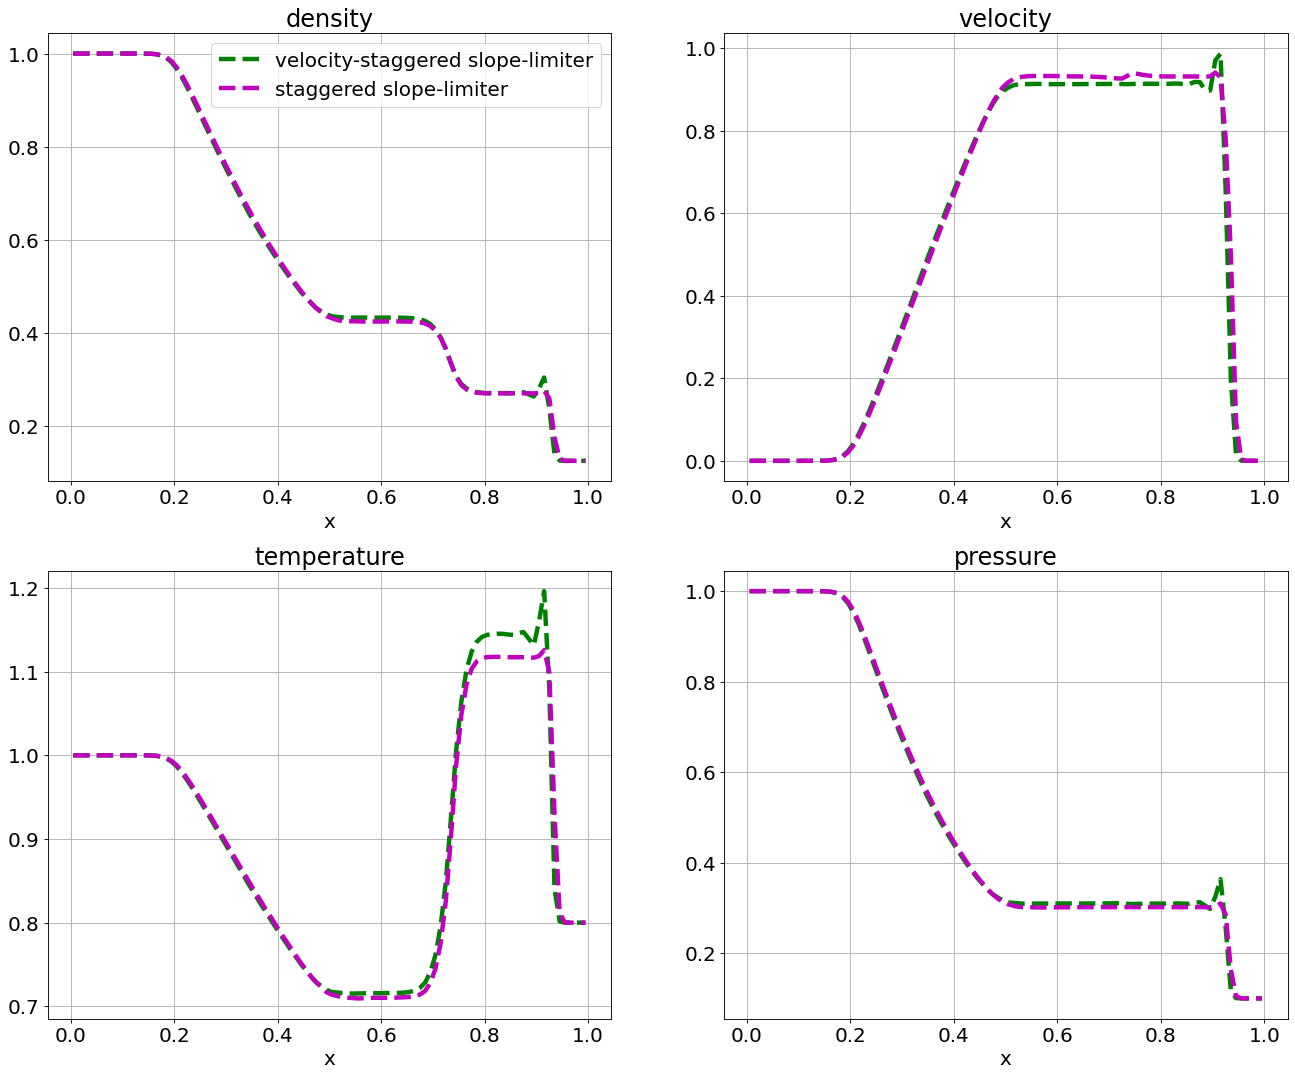

In [5]:
# Toro - test 1 (from Chapter 4)
p_list = []
for p in [
    # {"type" : "staggered", "variant" : "explicit", "ls" : "m:"},
    {"type" : "velocity-staggered", "variant" : "slope-limiter", "ls" : "g--"},
    {"type" : "staggered", "variant" : "slope-limiter", "ls" : "m--"},
        ] :
    params = make_navier_stokes_input()
    params["grid"]["Nx"]= 100
    params["physical"]["gamma"] = 1.4
    params["init"] = {
        "type" : "riemann",
        "x_a" : 0.5, # location of jump
        "n_l" : 1,   # density left of jump
        "n_r" : 0.125,   # density right of jump
        "u_l" : 0,   # velocity left of jump
        "u_r" : 0,   # velocity right of jump
        "t_l" : 1,   # temperature left of jump
        "t_r" : 0.1/0.125, # temperature right of jump
    }
    params["ls"]= p["ls"]
    params["output"]["tend"] = 0.25
    params["timestepper"]["type"] = "ARK"
    params["timestepper"]["tableau"]  = "ARK-4-2-3"
#     params["timestepper"]["type"] = "ERK"
#     params["timestepper"]["tableau"]  = "Bogacki-Shampine-4-2-3"
    params["advection"] = p
    p_list.append(params)
    
print( "Remember that energy and momentum can enter/leave the domain")
plot_navier_stokes(p_list)

As we can see the velocity-staggered discretization has problems to resolve the shock correctly (this is somewhat expected as it is not a conservative discretization

Remember that energy and momentum can enter/leave the domain
velocity-staggered slope-limiter
	Function calls: 3201.0 Failed: 47.0
Nx = 100
staggered slope-limiter
	Function calls: 3216.0 Failed: 54.0
Nx = 100


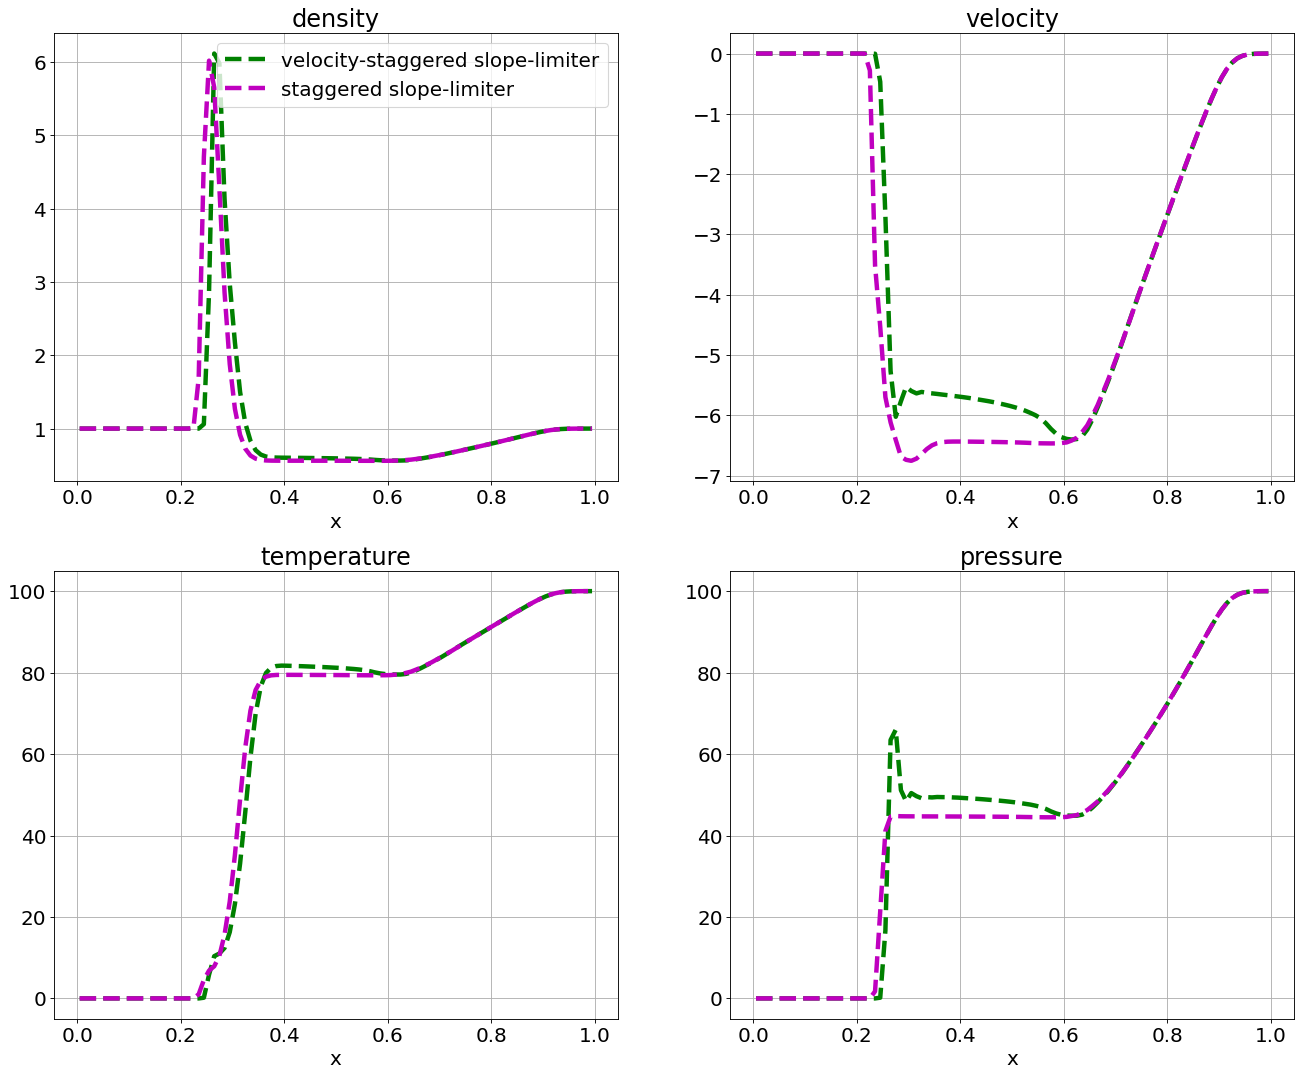

In [6]:
# Toro - test 4 (from Chapter 4)
p_list = []
for p in [
    # {"type" : "staggered", "variant" : "explicit", "ls" : "m:"},
    {"type" : "velocity-staggered", "variant" : "slope-limiter", "ls" : "g--"},
    {"type" : "staggered", "variant" : "slope-limiter", "ls" : "m--"},
        ] :
    params = make_navier_stokes_input()
    params["grid"]["Nx"]= 100
    params["physical"]["gamma"] = 1.4
    params["ls"]= p["ls"]
    params["output"]["tend"] = 0.035
    params["timestepper"]["type"] = "ARK"
    params["timestepper"]["tableau"]  = "ARK-4-2-3"
#     params["timestepper"]["type"] = "ERK"
#     params["timestepper"]["tableau"]  = "Bogacki-Shampine-4-2-3"
    params["advection"] = p
    p_list.append(params)
    
print( "Remember that energy and momentum can enter/leave the domain")
plot_navier_stokes(p_list)

- the original schemes of 1st and 2nd order converge to the correct solution as advertised

staggered semi-implicit
	Function calls: 4186.0 Failed: 0.0
Nx = 200
staggered slope-limiter
	Function calls: 5554.0 Failed: 100.0
Nx = 200
staggered explicit
	Function calls: 5248.0 Failed: 2.0
Nx = 200
staggered slope-limiter-explicit
	Function calls: 6974.0 Failed: 165.0
Nx = 200
velocity-staggered semi-implicit
	Function calls: 3718.0 Failed: 0.0
Nx = 200
velocity-staggered explicit
	Function calls: 5424.0 Failed: 1.0
Nx = 200
velocity-staggered slope-limiter-explicit
	Function calls: 6683.0 Failed: 120.0
Nx = 200
velocity-staggered slope-limiter
	Function calls: 5367.0 Failed: 101.0
Nx = 200


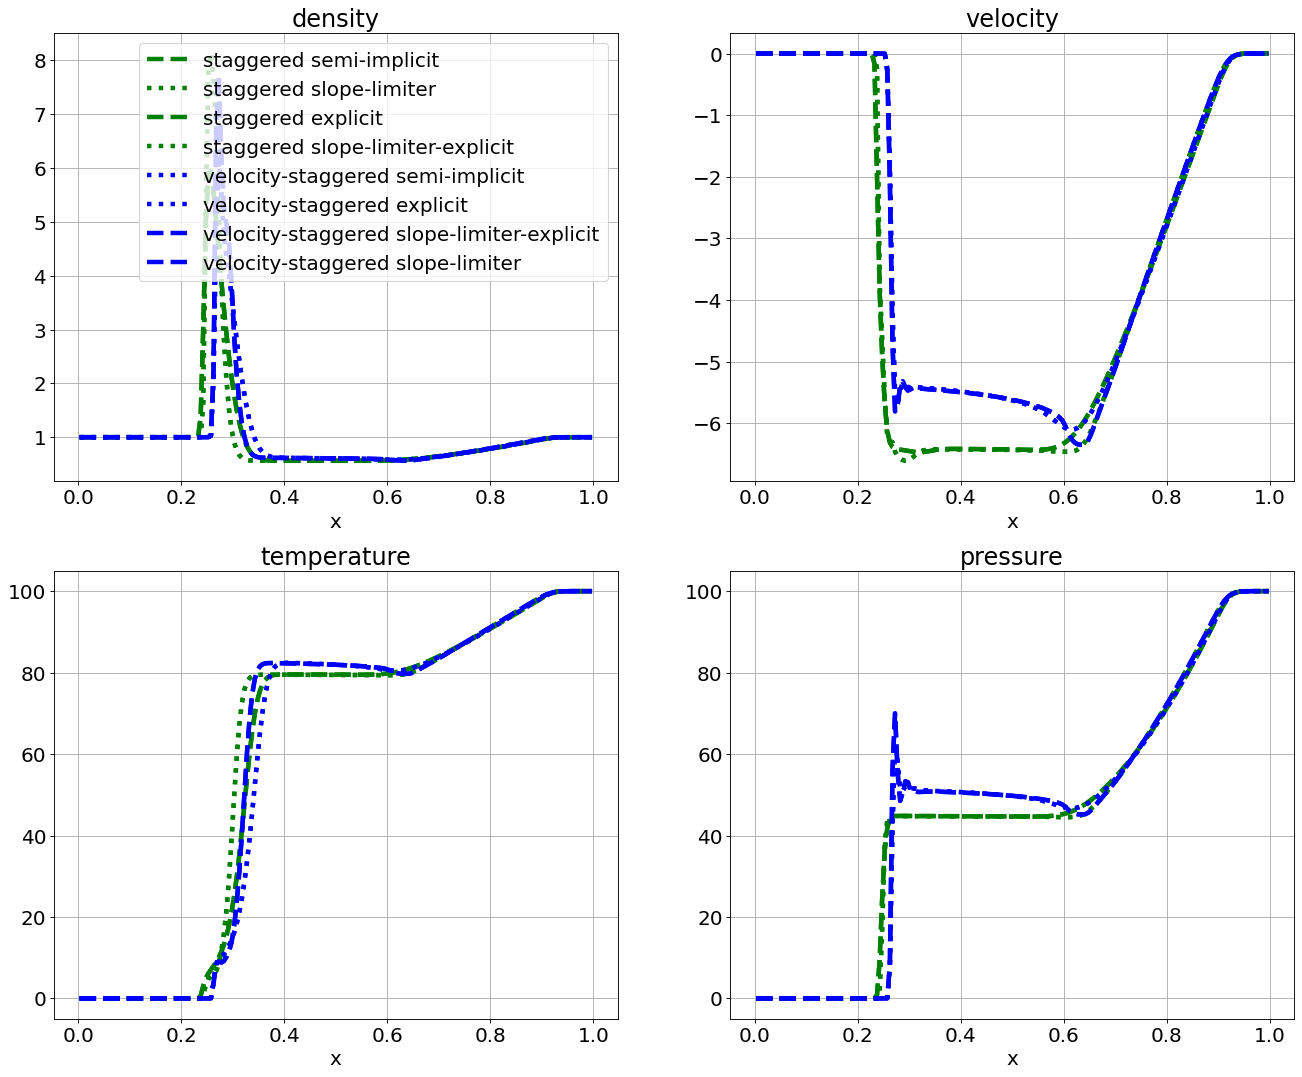

In [7]:
p_list = []
for p in [
    {"type" : "staggered", "variant" : "original", "ls" : "g--"},
    {"type" : "staggered", "variant" : "slope-limiter", "ls" : "g:"},
    {"type" : "staggered", "variant" : "explicit", "ls" : "g--"},
    {"type" : "staggered", "variant" : "slope-limiter-explicit", "ls" : "g:"},
    {"type" : "velocity-staggered", "variant" : "original", "ls" : "b:"},
    {"type" : "velocity-staggered", "variant" : "explicit", "ls" : "b:"},
    {"type" : "velocity-staggered", "variant" : "slope-limiter-explicit", "ls" : "b--"},
    {"type" : "velocity-staggered", "variant" : "slope-limiter", "ls" : "b--"},
         ] :
    params = make_navier_stokes_input()
    params["grid"]["Nx"]= 200
    params["output"]["tend"] = 0.035
    params["ls"] = p["ls"]
    params["timestepper"]["type"] = "ARK"
    params["timestepper"]["tableau"]  = "ARK-4-2-3"
    if( p["variant"] == "explicit" or p["variant"] == "slope-limiter-explicit") :
        params["timestepper"]["type"] = "ERK"
        params["timestepper"]["tableau"]  = "Bogacki-Shampine-4-2-3"
    params["advection"] = p
    p_list.append(params)
plot_navier_stokes(p_list)

Now we initialize a plane wave in the density and zero velocity. We observe the formation of shocks. Due to Burger's term the wave crest travels faster than the valley. We investigate the addition of a small viscosity.
Since we do not have an analytical solution we treat a high resolution staggered scheme as the true solution:

staggered slope-limiter
	Function calls: 6411.0 Failed: 313.0
Nx = 1000
staggered explicit
	Function calls: 4380.0 Failed: 91.0
Nx = 1000
velocity-staggered explicit
	Function calls: 4327.0 Failed: 95.0
Nx = 1000


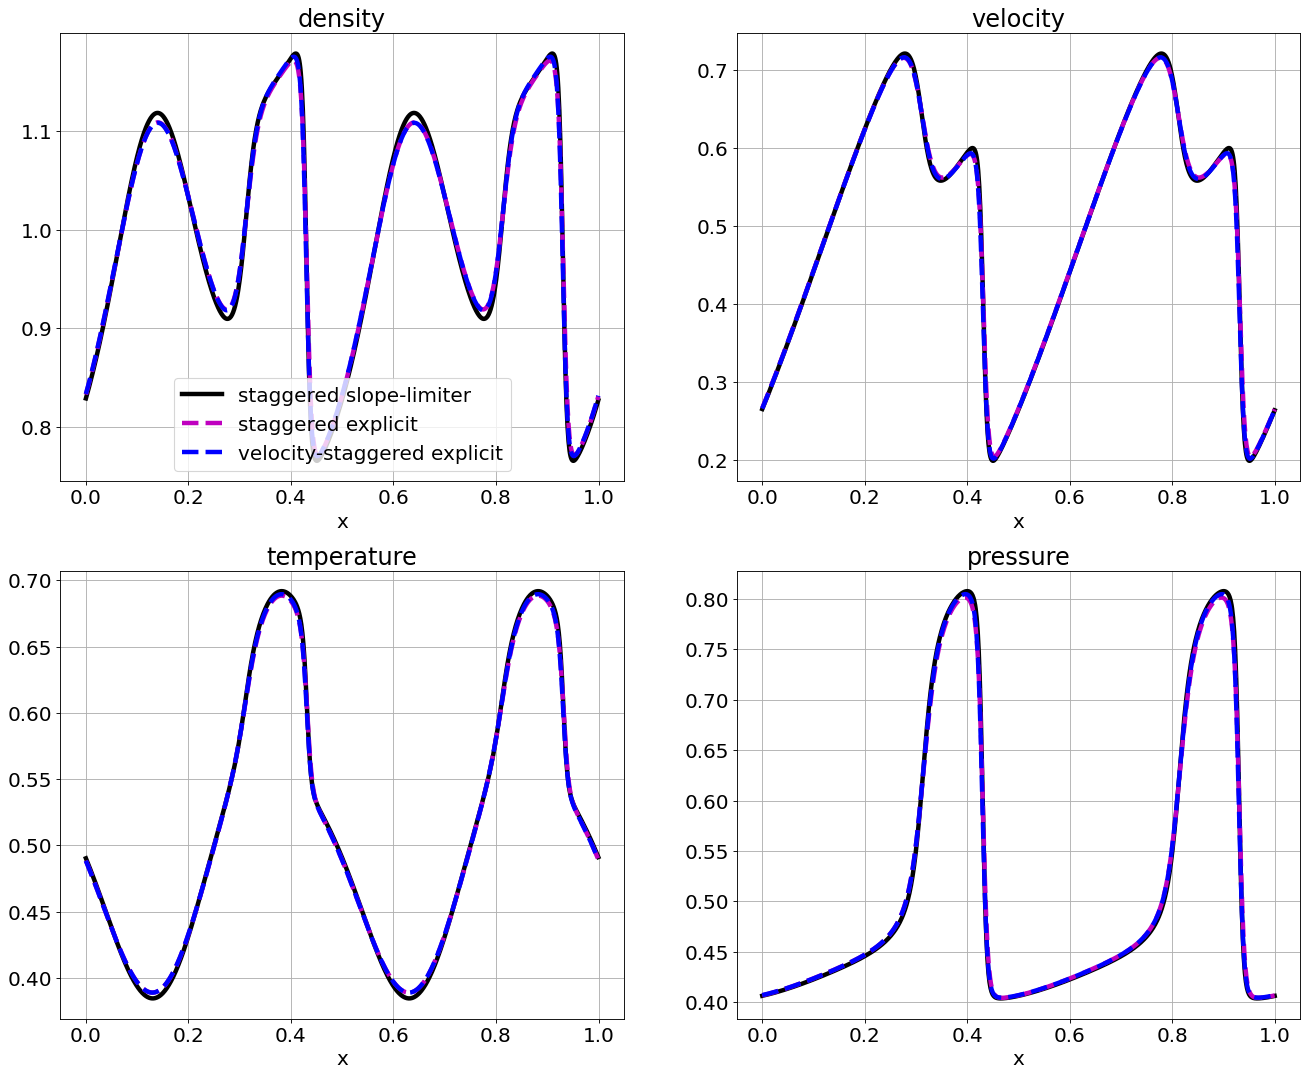

In [8]:
p_list = []
for p in [
    {"type" : "high_res", "ls" : "k-"},
#     {"type" : "staggered", "variant" : "original", "ls" : "g--"},
#     {"type" : "staggered", "variant" : "slope-limiter", "ls" : "g:"},
    {"type" : "staggered", "variant" : "explicit", "ls" : "m--"},
#     {"type" : "staggered", "variant" : "slope-limiter-explicit", "ls" : "g:"},
#     {"type" : "velocity-staggered", "variant" : "original", "ls" : "b:"},
    {"type" : "velocity-staggered", "variant" : "explicit", "ls" : "b--"},
    # {"type" : "velocity-staggered", "variant" : "slope-limiter-explicit", "ls" : "b:"},
         ] :
    params = make_navier_stokes_input()
    params["grid"]["Nx"]= 1000
    params["ls"] = p["ls"]
    if( p["type"] == "high_res") :
        params["grid"]["Nx"] = 1000
        p["type"] = "staggered"
        p["variant"] = "slope-limiter"
    params["init"] = {
        # A sine wave in density with 0 velocity
        "type" : "wave",
        "n_0" : 1.0,
        "u_0" : 0.5,
        "t_0" : 0.5,
        "A" : 0.2,
        "B" : 0.1,
        "C" : 0.2,
        "k" : 4*np.pi,
    }
    params["bc"] = {"density" : "PER", "velocity" : "PER", "temperature" : "PER"}
    params["physical"]["nu_n"] = 1e-3
    params["physical"]["nu_u"] = 1e-3
    params["physical"]["nu_t"] = 1e-3
    params["output"]["tend"] = 0.5
    params["timestepper"]["type"] = "ARK"
    params["timestepper"]["tableau"]  = "ARK-4-2-3"
    if( p["variant"] == "explicit" or p["variant"] == "slope-limiter-explicit") :
        params["timestepper"]["type"] = "ERK"
        params["timestepper"]["tableau"]  = "Bogacki-Shampine-4-2-3"
    params["physical"] ["gamma"] = 1.4
#     params["timestepper"]["type"] = "ERK"
#     params["timestepper"]["tableau"]  = "Euler"
    params["advection"] = p
    p_list.append(params)
plot_navier_stokes(p_list)

In [9]:
# The mms method is to check that all terms are implemented correctly
# Maybe this should be presented in a nice table
p_list = []
for p in [
    # {"type" : "staggered", "variant" : "explicit"},
    {"type" : "staggered", "variant" : "slope-limiter-explicit"},
    # {"type" : "velocity-staggered", "variant" : "explicit"},
    {"type" : "velocity-staggered", "variant" : "slope-limiter-explicit"},
         ] :
    for Nx in [100,200,400,800,1600,3200]:
        params = make_navier_stokes_input()
        params["grid"]["Nx"]= Nx
        params["output"]["tend"] = 0.1
        params["init"] = {
             # Manufactured solution without shock
            "type" : "mms",
            "n_0" : 1,
            "u_0" : 0.5,
            "t_0" : 0.75,
            "A" : 0.2,
            "B" : 0.1,
            "C" : 0.2,
            "k" : 4*np.pi,
            "v" : 1
        }
        params["bc"] = {"density":"PER", "velocity" : "PER", "temperature" : "PER"}
        params["physical"]["nu_u"] = 1e-3
        params["physical"]["nu_n"] = 1e-3
        params["physical"]["nu_t"] = 1e-3
        params["physical"]["gamma"] = 1.4
        params["timestepper"]["type"] = "ARK"
        params["timestepper"]["tableau"]  = "ARK-4-2-3"
        params["advection"] = p
        rep.clean()
        rep.run( params)
        ncin = Dataset( "temp.nc", 'r', format="NETCDF4")
        var = ncin.variables
        last_idx  = var["time"].shape[0]-1
        error_n = var["density"][:,:] - var["density_ana"][:,:]
        norm_ana_n = np.linalg.norm( var["density_ana"][last_idx,:], ord=1)
        error_u = var["velocity"][:,:] - var["velocity_ana"][:,:]
        norm_ana_u = np.linalg.norm( var["velocity_ana"][last_idx,:], ord=1)
        error_t = var["temperature"][:,:] - var["temperature_ana"][:,:]
        norm_ana_t = np.linalg.norm( var["temperature_ana"][last_idx,:], ord=1)
        #norm_ana = np.size( error[last_idx,:])
        l = f"{params['advection']['type']}"
        if( "variant" in params["advection"].keys() ):
            l = l + f" {params['advection']['variant']}"
        print( f"{l} {Nx} {np.linalg.norm(error_n[last_idx,:],ord=1)/norm_ana_n}\
\t{np.linalg.norm(error_u[last_idx,:], ord=1)/norm_ana_u}\
\t{np.linalg.norm(error_t[last_idx,:], ord=1)/norm_ana_t}")
        ncin.close()

staggered slope-limiter-explicit 100 0.0006518594228197063	0.0012593054476386048	0.00041112164797621963
staggered slope-limiter-explicit 200 0.00016968491355969783	0.0003167265102146344	0.00010304589000291224
staggered slope-limiter-explicit 400 4.2782516858140276e-05	7.929407265568594e-05	2.55697499817098e-05
staggered slope-limiter-explicit 800 1.0644316226934014e-05	1.978952997435057e-05	6.324362017001151e-06
staggered slope-limiter-explicit 1600 3.052250642491053e-06	5.071277280465566e-06	1.7931632997689185e-06
staggered slope-limiter-explicit 3200 3.775958755928184e-06	6.273679329261012e-06	1.0417470989961264e-05
velocity-staggered slope-limiter-explicit 100 0.0005762710005590212	0.0011634199587932173	0.00038474939629282433
velocity-staggered slope-limiter-explicit 200 0.00014850072649621072	0.0002883048500554586	9.682884855177395e-05
velocity-staggered slope-limiter-explicit 400 3.7354775384567664e-05	7.218954278990414e-05	2.403381134199726e-05
velocity-staggered slope-limiter-ex